In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from scipy.io import savemat
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, BatchNormalization

In [25]:
# Load dataset
file_path = 'F:\\Olivier\\dataset_thesis_complete.csv'
df = pd.read_csv(file_path)
df = df[df['survival_time'] < 1280]
df.head()

,patient_id,PC1,PC2,PC3,PC4,LAST_MR,survival_time,growth,Age,sex,...,Z,Vol_FL,Vol_T1,Vol_Nec,mu1,mu2,Vol_rat,Vol_rat2,mu1mu2,mu2mu1
0,me_407_0_0,18.864999,-5.355469,10.171185,-18.664959,645,930.0,0.0582,52,1,...,0.463,5.865,5.661,1.470,3.342813,1.585938,1.036036,0.965217,2.107783,0.474432
2,me_410_0_0,28.036510,-4.298905,-9.936605,-10.043803,20,252.0,0.1470,46,0,...,0.450,54.197,61.727,30.670,0.933812,0.178977,0.878011,1.138938,5.217492,0.191663
3,me_414_0_0,18.573250,-8.099408,-9.511910,-8.154779,9,97.0,0.0190,62,0,...,0.294,70.000,71.157,33.145,2.951783,4.223596,0.983740,1.016529,0.698879,1.430863
4,me_420_0_0,19.139756,-6.360113,-4.527472,-9.375182,373,414.0,0.1470,72,0,...,0.452,140.753,28.384,5.416,0.933812,0.099829,4.958885,0.201658,9.354143,0.106904
5,me_424_0_0,24.681227,-5.076373,-8.696319,-6.463476,388,688.0,0.0414,55,1,...,0.292,4.600,83.104,35.087,3.734989,2.489993,0.055352,18.066087,1.500000,0.666667


In [33]:
# Define features and target
X = df.drop(columns=['patient_id', 'growth', 'LAST_MR', 'survival_time', "Infiltration", 'Time', 'Vol_FL', 'Vol_T1', 'mu1', 'mu2', 'X', 'Y', 'Z', 'mu1mu2', 'PC1', 'PC2', 'PC4', 'Vol_rat2']).values
y = (df['LAST_MR'] / 30).values.reshape(-1, 1) 

In [35]:
# Define MDN parameters
n_components = 3  # Number of mixture components
input_dim = X.shape[1]

def mdn_loss(y_true, y_pred):
    out_mu = tf.nn.relu(y_pred[:, :n_components])  # Ensure non-negative means
    out_var = tf.clip_by_value(tf.math.softplus(y_pred[:, n_components:2*n_components]), 1e-6, 1e6)
    out_pi = tf.nn.softmax(y_pred[:, 2*n_components:])

    y_true = tf.tile(y_true, [1, n_components])
    result = out_pi * tf.exp(-0.5 * tf.square((y_true - out_mu) / (out_var + 1e-6)) / (out_var * tf.sqrt(2 * np.pi) + 1e-6))
    result = tf.reduce_sum(result, axis=1)
    result = -tf.math.log(result + 1e-6)
    return tf.reduce_mean(result)

# Build the MDN model
input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(128, activation='relu', kernel_initializer='he_normal')(input_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dense(128, activation='relu', kernel_initializer='he_normal')(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)
output_layer = Dense(n_components*3, kernel_initializer='he_normal')(hidden_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=mdn_loss)

# Define Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# LOOCV
unpdfs = []
predicted_modes = []
predicted_variances = []

# Store true and predicted values for comparison
results = []

for i in range(X.shape[0]):
    print(f"Processing patient {i+1}/{X.shape[0]}")

    X_train = np.delete(X, i, axis=0)
    y_train = np.delete(y, i, axis=0)
    X_val = X[i:i+1]
    y_val = y[i:i+1]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=500, verbose=0, callbacks=[early_stopping])

    # Predict for the validation set
    prediction = model.predict(X_val_scaled)
    pi = tf.nn.softmax(prediction[:, 2*n_components:]).numpy()
    mu = tf.nn.relu(prediction[:, :n_components])  # Ensure non-negative means
    var = tf.clip_by_value(tf.math.softplus(prediction[:, n_components:2*n_components]), 1e-6, 1e6).numpy()

    print(f"pi: {pi}")
    print(f"mu: {mu}")
    print(f"var: {var}")

    Survival_days_range = np.linspace(0, 72, 100).reshape(-1, 1)
    unpdf = np.zeros_like(Survival_days_range)
    variance = np.zeros_like(Survival_days_range)

    for pi_j, mu_j, var_j in zip(pi[0], mu[0], var[0]):
        unpdf += pi_j * norm.pdf(Survival_days_range, mu_j, np.sqrt(var_j))
        variance += pi_j * (var_j + mu_j**2)

    variance -= np.square(Survival_days_range[np.argmax(unpdf)])

    unpdfs.append(unpdf)
    predicted_mode = Survival_days_range[np.argmax(unpdf)]
    predicted_modes.append(predicted_mode)
    predicted_variances.append(variance[np.argmax(unpdf)])

    # Append true and predicted values for this patient to results
    results.append({'Patient': i + 1, 'True Survival Time': y_val[0][0], 'Predicted Survival Time': predicted_mode[0]})

# Save unpdfs
data_to_save = {f'unpdf_{i+1}': unpdf for i, unpdf in enumerate(unpdfs)}
savemat('unpdfsipy_rad.mat', data_to_save)

# Calculate MSE
predicted_modes = np.array(predicted_modes).reshape(-1, 1)
mse = np.mean((y - predicted_modes)**2)
print(f"Mean Squared Error: {mse:.2f}")

# Print predicted values for each patient
results_df = pd.DataFrame(results)
print(results_df)

Processing patient 1/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
pi: [[0.753144   0.23310652 0.01374948]]
mu: [[4.0539327 0.        0.       ]]
var: [[0.74439615 0.70581114 1.8909285 ]]
Processing patient 2/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
pi: [[0.11020986 0.24816853 0.64162165]]
mu: [[0.29453942 0.         0.40341935]]
var: [[1.5283644  1.6013646  0.35344812]]
Processing patient 3/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
pi: [[9.7522730e-01 6.8499718e-04 2.4087723e-02]]
mu: [[0.5492289 0.        0.       ]]
var: [[1.1221063  0.04400165 0.83375645]]
Processing patient 4/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
pi: [[0.02110685 0.977247   0.00164616]]
mu: [[0. 0. 0.]]
var: [[0.08411155 0.0791693  0.16832855]]
Processing patient 5/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
pi: [[0.03223849 0.00834026 0.9594213 ]]
mu: [[0.9532453 0.        0.       ]]
var: [[1.184574  0.9952655 6.565517 ]]
Processing patient 6/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
pi: [[0.04008258 0.01070087 0.9492

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

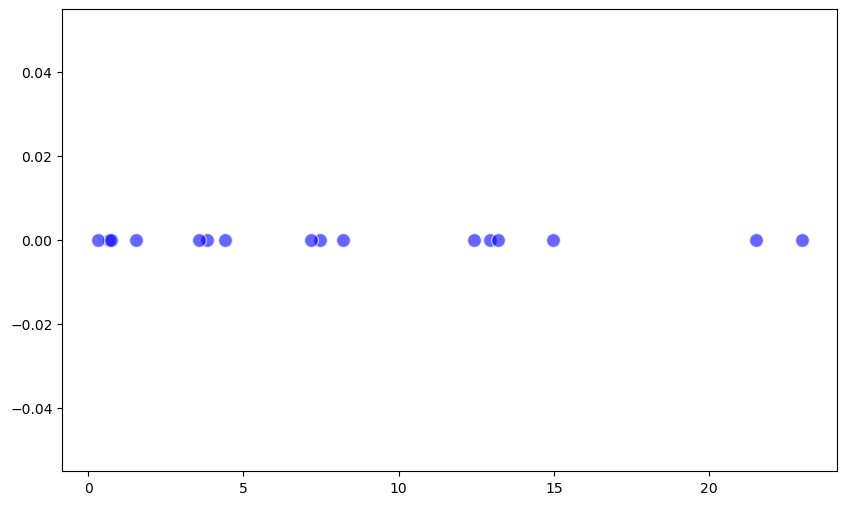

In [21]:
import matplotlib.pyplot as plt
# Scatter Plot with Line y = x
plt.figure(figsize=(10, 6))
plt.scatter(y, predicted_modes, c='blue', label='Predicted Modes', alpha=0.6, edgecolors='w', s=100)
plt.plot([0, max(y)], [0, max(y)], 'r--', label='y = x')
plt.xlabel('True Survival Time (months)')
plt.ylabel('Predicted Survival Time (months)')
plt.title('Validation: True vs. Predicted Survival Time')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()